### Import Libraries

In [9]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import strategy as mod

from random import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

sns.set(style='ticks')
warnings.filterwarnings('ignore')

In [2]:
# Load and clean the data

data = pd.read_csv("S:/Dissertation 2023/Stock market analysis/stock_market_strategy_analysis/data_files/itc.csv",
                   index_col=0, parse_dates=[0], dayfirst=True)
# Step 1
itc_df = mod.prepare_data(data)

## Strategy I - 50-day & 100-day EMA crossover

In [3]:
# calculate the indicators
data_strat_1 = mod.ema_crossover(itc_df, itc_df['close'])

In [4]:
# Identify optimal buy-sell points

buy_sell_data_1 = mod.get_signals_for_strategy_1(data_strat_1.copy(deep=True))

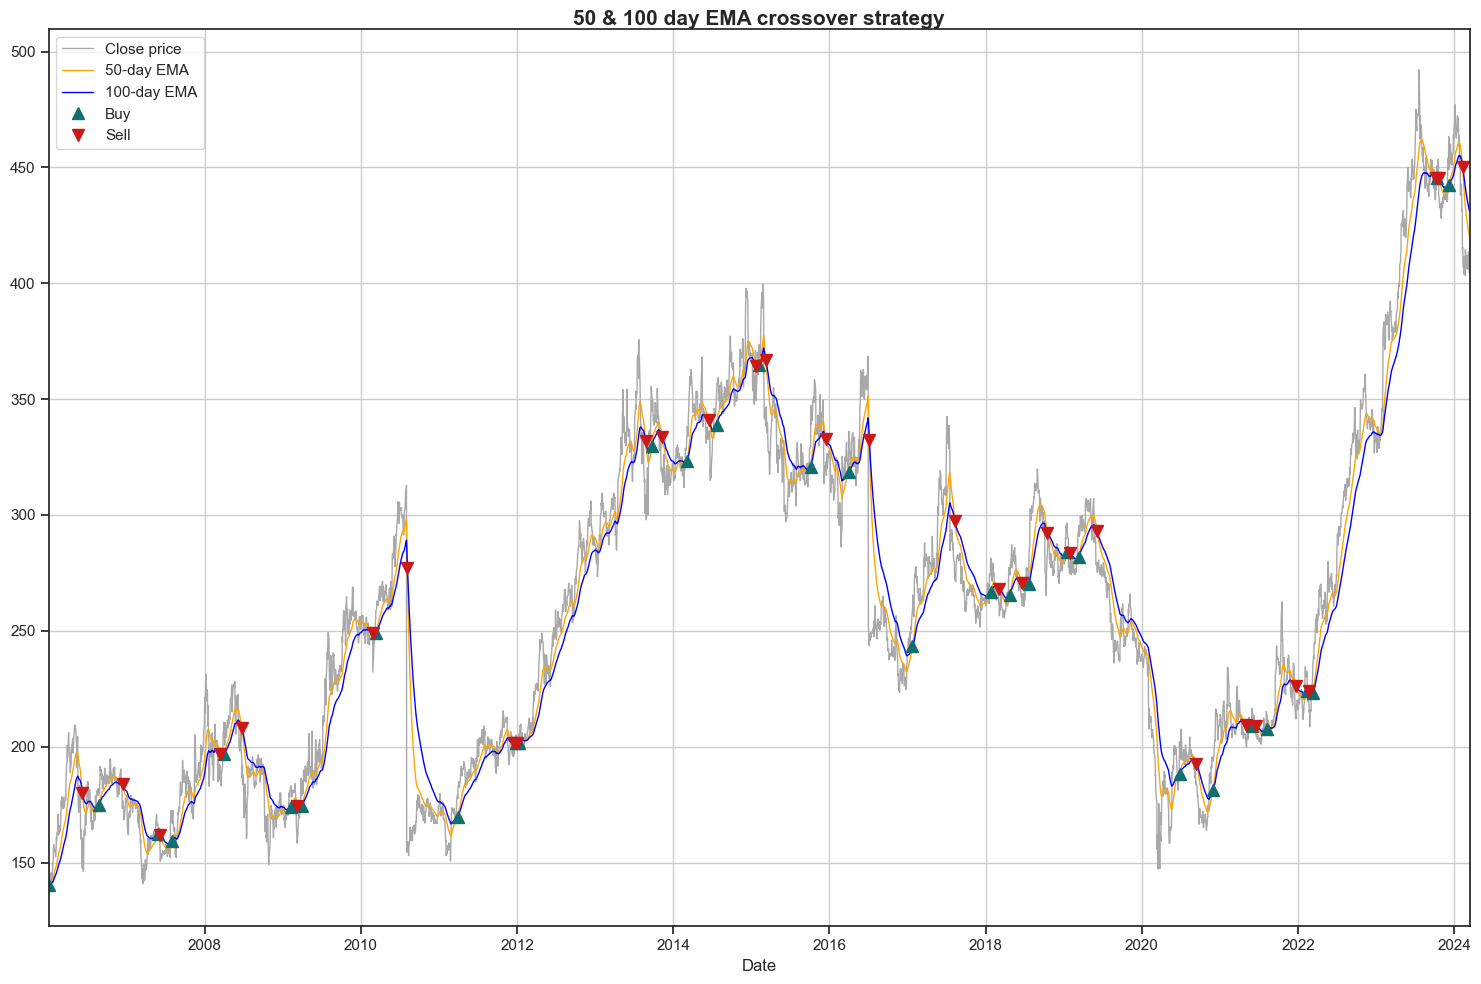

In [5]:
# visualize the buy sell points with the technical indicators in place

buy_signals_1 = buy_sell_data_1.loc[buy_sell_data_1['position'] == 'buy', 'ema_50']
sell_signals_1 = buy_sell_data_1.loc[buy_sell_data_1['position'] == 'sell', 'ema_50']

# Step 6
fig1, ax1 = plt.subplots(nrows=1, figsize=(15, 10))

ax1.plot(buy_sell_data_1.close, color='darkgrey', label='Close price', linewidth=1)
ax1.plot(buy_sell_data_1.ema_50, color='orange', label='50-day EMA', linewidth=1)
ax1.plot(buy_sell_data_1.ema_100, color='blue', label='100-day EMA', linewidth=1)
ax1.set_xlim([buy_sell_data_1.index[0], buy_sell_data_1.index[-1]])

ax1.plot(buy_signals_1.index,
         buy_signals_1,
         '^', markersize=8, color='#116D6E', label='Buy')
ax1.plot(sell_signals_1.index,
         sell_signals_1,
         'v', markersize=8, color='#CD1818', label='Sell')
ax1.legend()

ax1.text(x=0.5, y=1, s='50 & 100 day EMA crossover strategy', fontsize=15, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

plt.xlabel('Date')
plt.tight_layout()
plt.grid()
plt.show()

In [6]:
# Calculate returns

cum_ret_1, portfolio_amount_1 = mod.calculate_cumulative_returns(buy_sell_data_1)

annual_return_1 = mod.calculate_annual_return(buy_sell_data_1, cumulative_return=cum_ret_1)

return_on_investment_1 = mod.calculate_roi(portfolio_amount_1)

print(f"ROI of strategy 1: {return_on_investment_1:.2f}%")
print(f"Annual Return of strategy 1: {annual_return_1 * 100:.2f}%")
print(f"Portfolio Amount at the End of the Investment Period: {portfolio_amount_1:.2f}")

ROI of strategy 1: -24.58%
Annual Return of strategy 1: -1.39%
Portfolio Amount at the End of the Investment Period: 7542.01


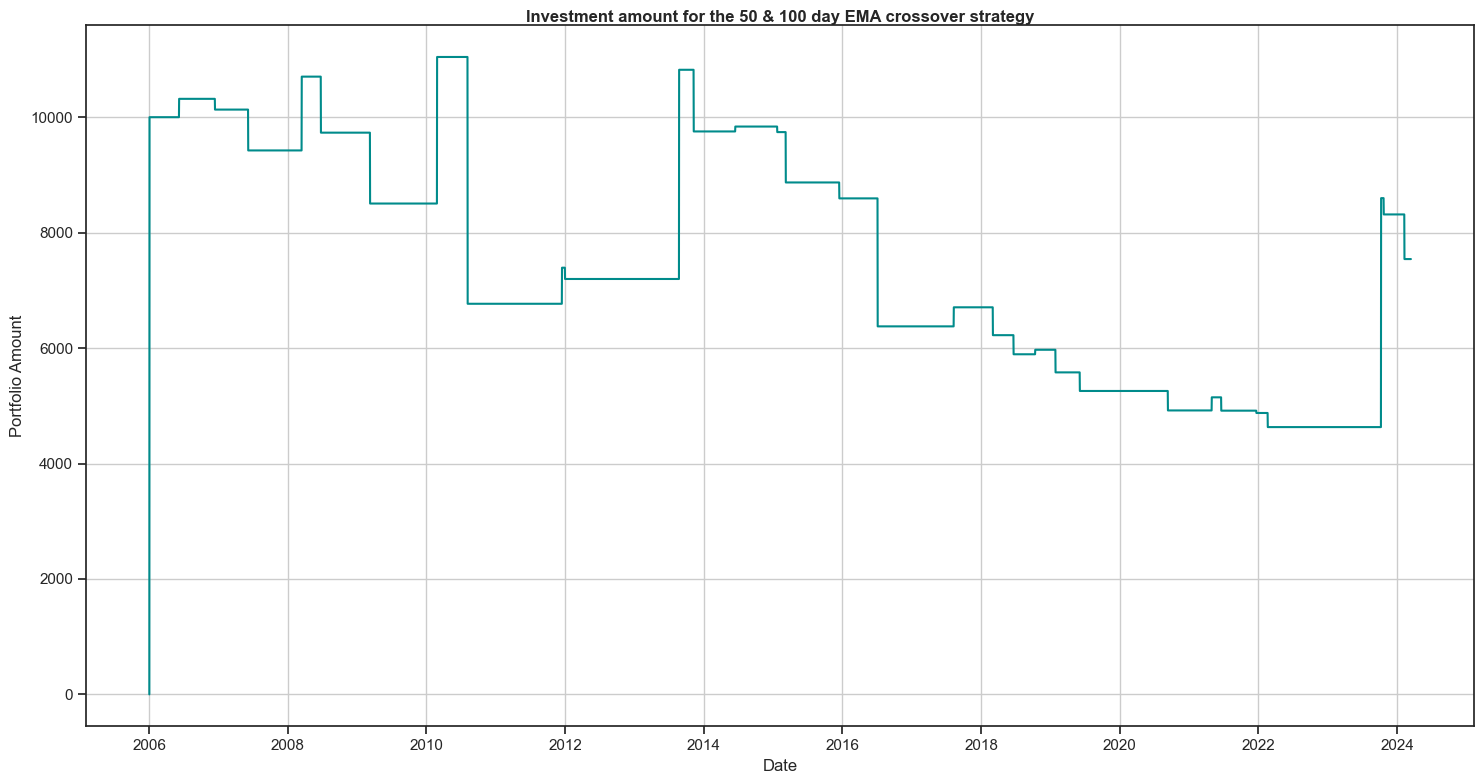

In [7]:
# Visualize the cumulative returns over the investment period

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 8))

# Plot the cumulative returns
ax1.plot(buy_sell_data_1.index, buy_sell_data_1['investment_value'], color='darkcyan', label='Portfolio Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Amount')
ax1.tick_params('y')
ax1.grid()
ax1.text(x=0.5, y=1, s='Investment amount for the 50 & 100 day EMA crossover strategy', fontsize=12, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

plt.tight_layout()
plt.show()

In [37]:
buy_sell_data_1['signal'].value_counts()

 0    6585
 1      31
-1      31
Name: signal, dtype: int64

Accuracy for default Decision tree model: 98.10%
Classification Report - Model 1

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         9
           0       0.99      0.99      0.99      1978
           1       0.12      0.12      0.12         8

    accuracy                           0.98      1995
   macro avg       0.37      0.37      0.37      1995
weighted avg       0.98      0.98      0.98      1995



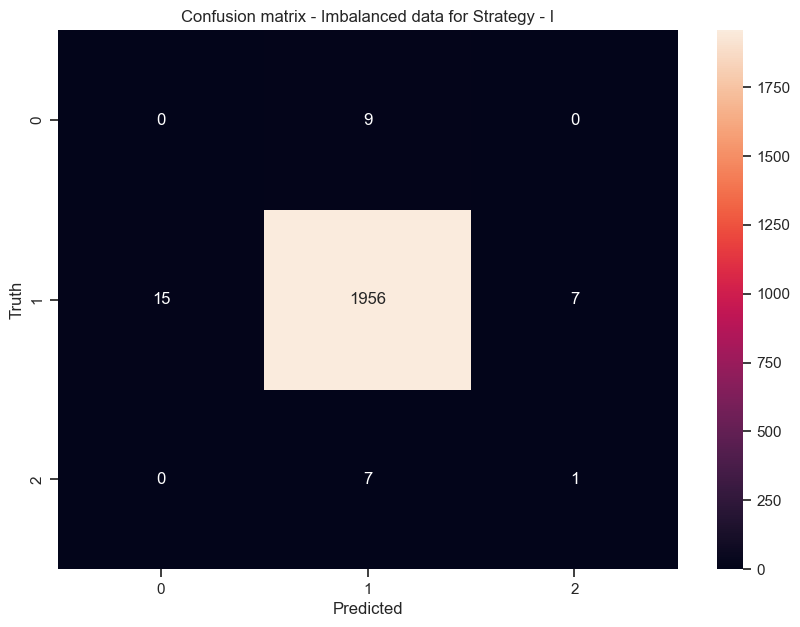

In [39]:
# Model 1: Decision tree without SMOTE analysis - Imbalanced dataset

# Identify predictors and target variable
X_1 = buy_sell_data_1[['close', 'ema_50', 'ema_100']]
y_1 = buy_sell_data_1['signal']

# Split data into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_1 = DecisionTreeClassifier()

# Fit the model to the training data
model_1.fit(X_train_1, y_train_1)

# Make predictions on the test set
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the model's accuracy
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for default Decision tree model: {accuracy_1*100:.2f}%")

# Classification report
print("Classification Report - Model 1\n")
print(classification_report(y_test_1, y_pred_1))

# Visualize the confusion matrix
cm_1 = confusion_matrix(y_test_1, y_pred_1)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Imbalanced data for Strategy - I")
plt.show()


 0    6584
 1    3292
-1    3292
Name: signal, dtype: int64
Accuracy for Decision tree model with SMOTE: 99.70%
Classification Report - Model 2

              precision    recall  f1-score   support

          -1       0.98      0.96      0.97       960
           0       0.96      0.97      0.97      1982
           1       0.96      0.95      0.96      1009

    accuracy                           0.96      3951
   macro avg       0.97      0.96      0.96      3951
weighted avg       0.96      0.96      0.96      3951



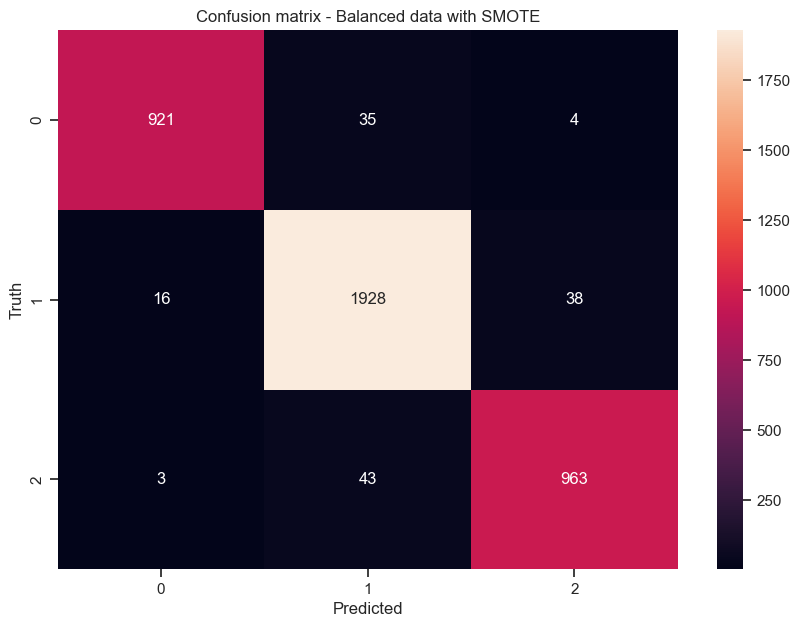

In [38]:
# Model 2: Decision tree model with SMOTE analysis on both train and test set

# Split the data into buy+50% hold and sell+50% hold
df1 = pd.concat([buy_sell_data_1[buy_sell_data_1.signal == 1], buy_sell_data_1[buy_sell_data_1.signal == 0].iloc[:3292]])
df2 = pd.concat([buy_sell_data_1[buy_sell_data_1.signal == -1], buy_sell_data_1[buy_sell_data_1.signal == 0].iloc[:3292]])

# SMOTE Analysis

X1 = df1[['close', 'ema_50', 'ema_100']]
y1 = df1['signal']
sm = SMOTE(random_state=657)
X1_new, y1_new = sm.fit_resample(X1, y1)

X2 = df2[['close', 'ema_50', 'ema_100']]
y2 = df2['signal']
sm = SMOTE()
X2_new, y2_new = sm.fit_resample(X2, y2)

# New dataframes with balanced labels

X_new = pd.concat([X1_new, X2_new])
y_new = pd.concat([y1_new, y2_new])

print(y_new.value_counts())

# Split data into train and test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_2 = DecisionTreeClassifier()

# Fit the model to the training data
model_2.fit(X_train_2, y_train_2)

# Make predictions on the test set
y_pred_2 = model_2.predict(X_test_2)

# Evaluate the model's accuracy
accuracy_2 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for Decision tree model with SMOTE: {accuracy_2*100:.2f}%")

# Classification report
print("Classification Report - Model 2\n")
print(classification_report(y_test_2, y_pred_2))

# Visualize the confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Balanced data with SMOTE")
plt.show()


## Strategy II - Bollinger bands with RSI

In [12]:
# Get the technical indicators for the strategy 2

data_strat_2 = mod.bollinger_bands_with_rsi(itc_df, itc_df['close'])

In [13]:
# Identify the buy-sell points

buy_sell_data_2 = mod.get_signals_for_strategy_2(data_strat_2.copy(deep=True))

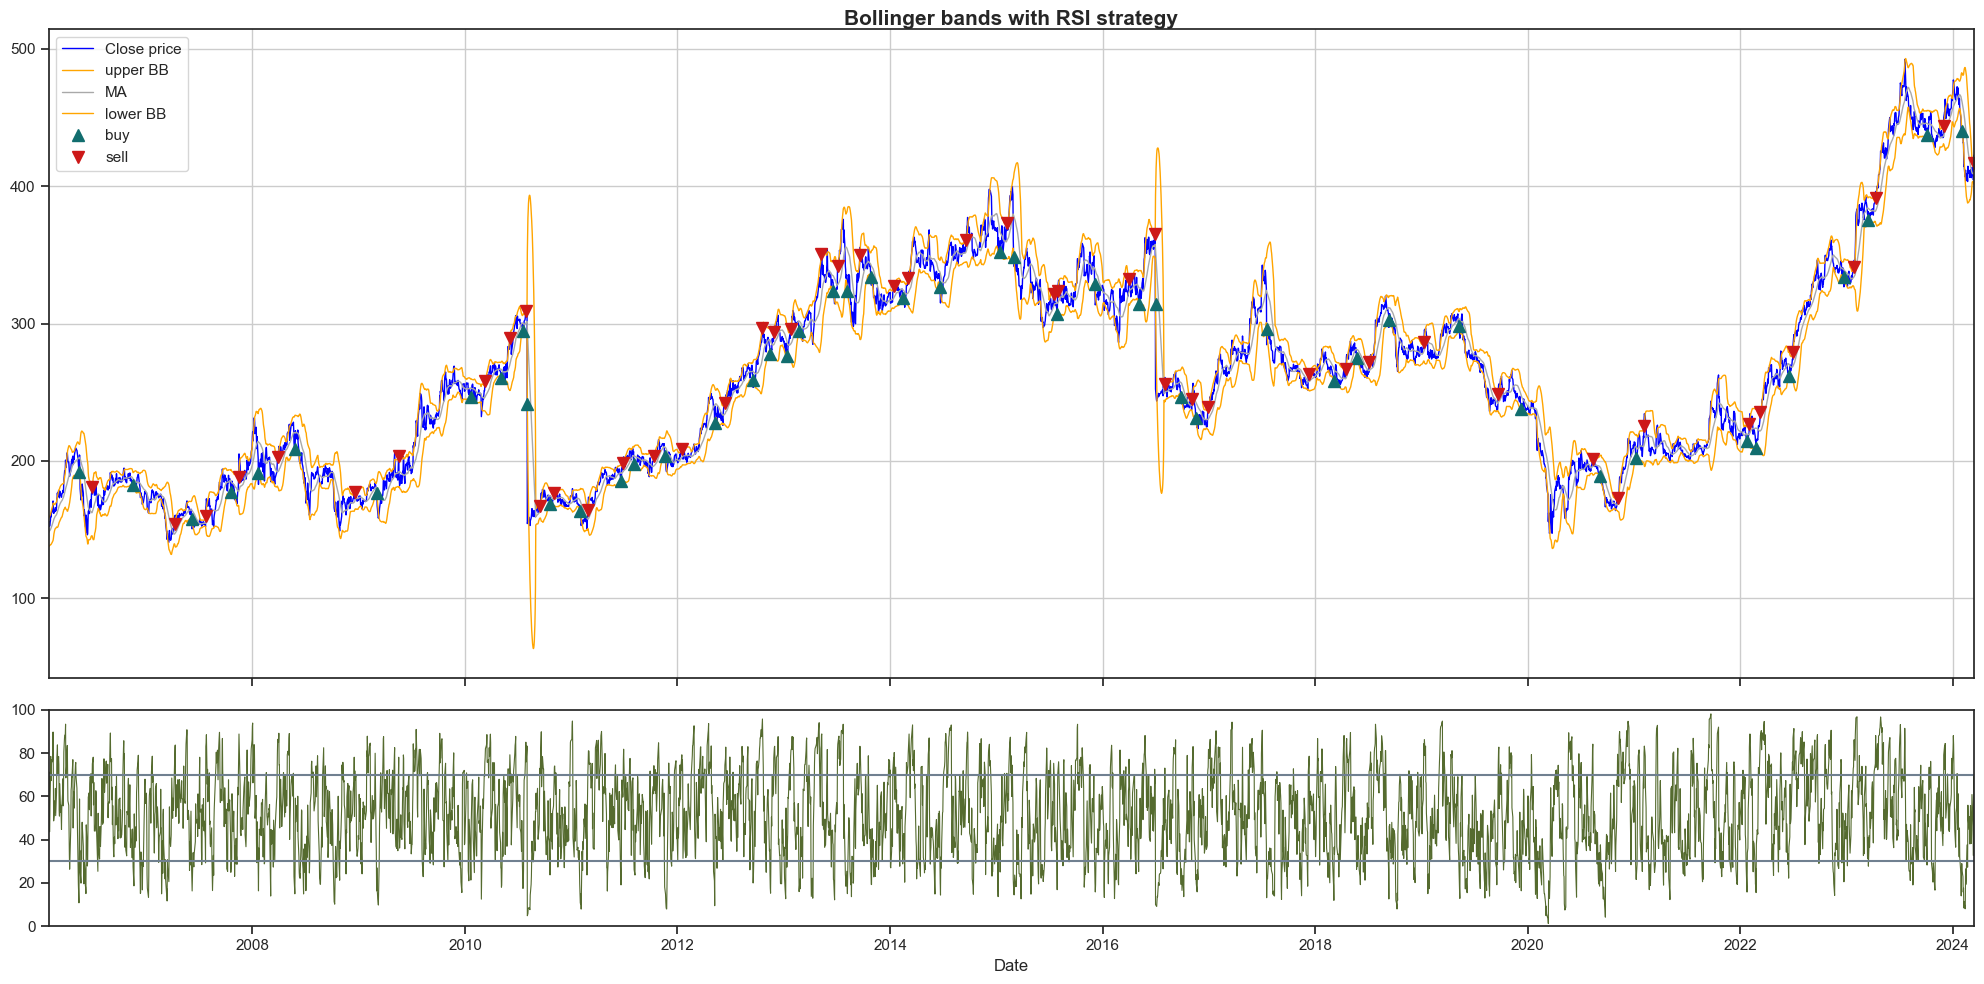

In [14]:
# visualize the buy sell points with the technical indicators in place

buy_signals_2 = buy_sell_data_2.loc[buy_sell_data_2['signal'] == 1, 'lower_bollinger_band']
sell_signals_2 = buy_sell_data_2.loc[buy_sell_data_2['signal'] == -1, 'upper_bollinger_band']

fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(buy_sell_data_2.close, color='blue', label='Close price', linewidth=1)
ax1.plot(buy_sell_data_2.upper_bollinger_band, color='orange', label='upper BB', linewidth=1)
ax1.plot(buy_sell_data_2.moving_average_line, color='darkgrey', label='MA', linewidth=1)
ax1.plot(buy_sell_data_2.lower_bollinger_band, color='orange', label='lower BB', linewidth=1)
ax1.set_xlim([buy_sell_data_2.index[0], buy_sell_data_2.index[-1]])

ax1.plot(buy_signals_2.index,
         buy_signals_2,
         '^', markersize=8, color='#116D6E', label='buy')
ax1.plot(sell_signals_2.index,
         sell_signals_2,
         'v', markersize=8, color='#CD1818', label='sell')
ax1.legend()
ax1.text(x=0.5, y=1, s='Bollinger bands with RSI strategy', fontsize=15, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

ax1.grid()

ax2.plot(buy_sell_data_2.rsi, color='darkolivegreen', linewidth=0.8)
ax2.axhline(y=30, color='slategrey', linestyle='-')
ax2.axhline(y=70, color='slategrey', linestyle='-')
ax2.set_ylim([0, 100])

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [15]:
# Calculate returns

cum_ret_2, portfolio_amount_2 = mod.calculate_cumulative_returns(buy_sell_data_2)

annual_return_2 = mod.calculate_annual_return(buy_sell_data_2, cumulative_return=cum_ret_2)

return_on_investment_2 = mod.calculate_roi(portfolio_amount_2)

print(f"ROI of strategy 2: {return_on_investment_2:.2f}%")
print(f"Annual Return of strategy 2: {annual_return_2 * 100:.2f}%")
print(f"Portfolio Amount at the End of the Investment Period: {portfolio_amount_2:.2f}")

ROI of strategy 2: 536.42%
Annual Return of strategy 2: -5.98%
Portfolio Amount at the End of the Investment Period: 63642.40


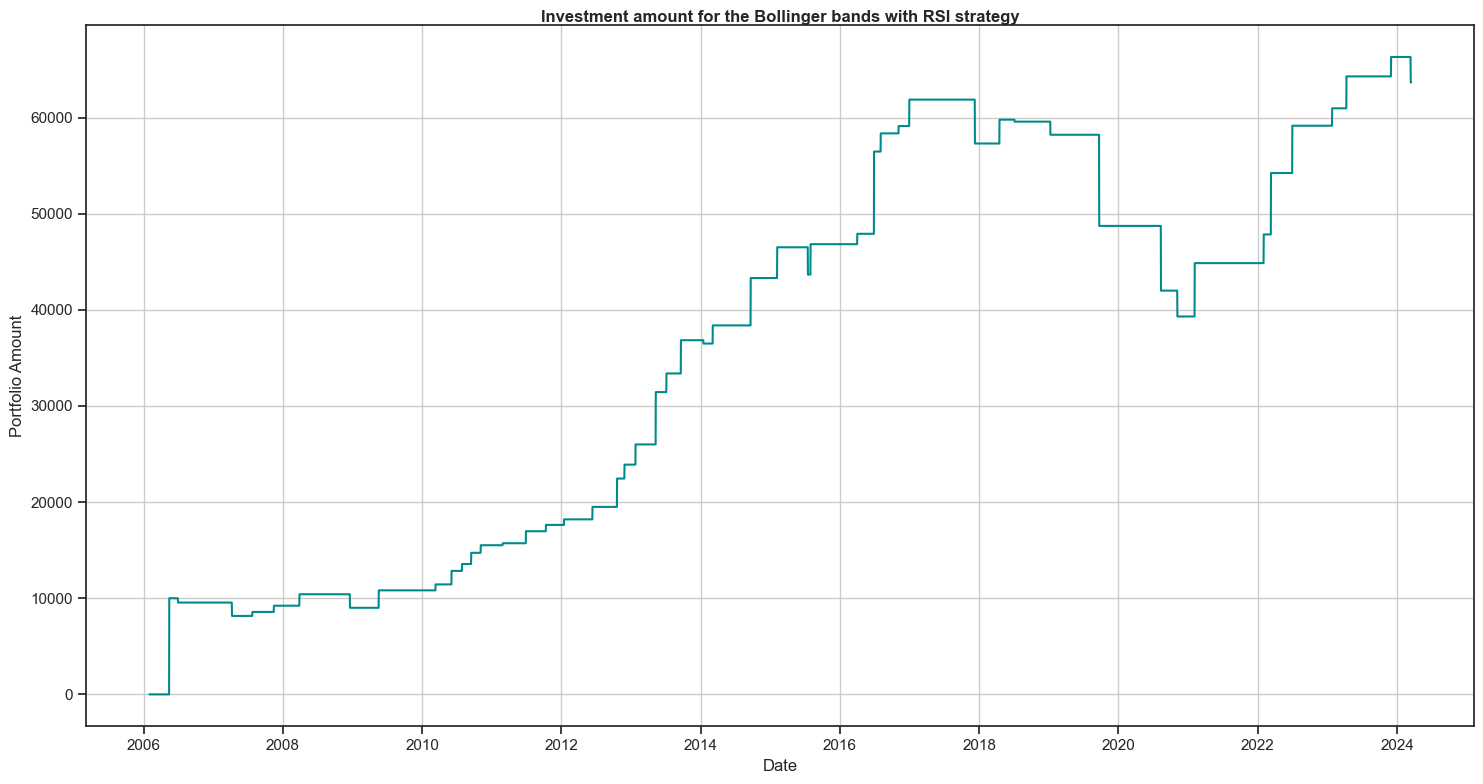

In [16]:
# Visualize the cumulative returns over the investment period

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 8))

# Plot the cumulative returns
ax1.plot(buy_sell_data_2.index, buy_sell_data_2['investment_value'], color='darkcyan', label='Portfolio Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Amount')
ax1.tick_params('y')
ax1.grid()
ax1.text(x=0.5, y=1, s='Investment amount for the Bollinger bands with RSI strategy', fontsize=12, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

plt.tight_layout()
plt.show()

In [25]:
buy_sell_data_2['signal'].value_counts()

 0    6520
 1      49
-1      49
Name: signal, dtype: int64

Accuracy for default Decision tree model: 96.93%
Classification Report - Model 1

              precision    recall  f1-score   support

          -1       0.04      0.08      0.05        13
           0       0.99      0.98      0.98      1964
           1       0.00      0.00      0.00         9

    accuracy                           0.97      1986
   macro avg       0.34      0.35      0.35      1986
weighted avg       0.98      0.97      0.97      1986



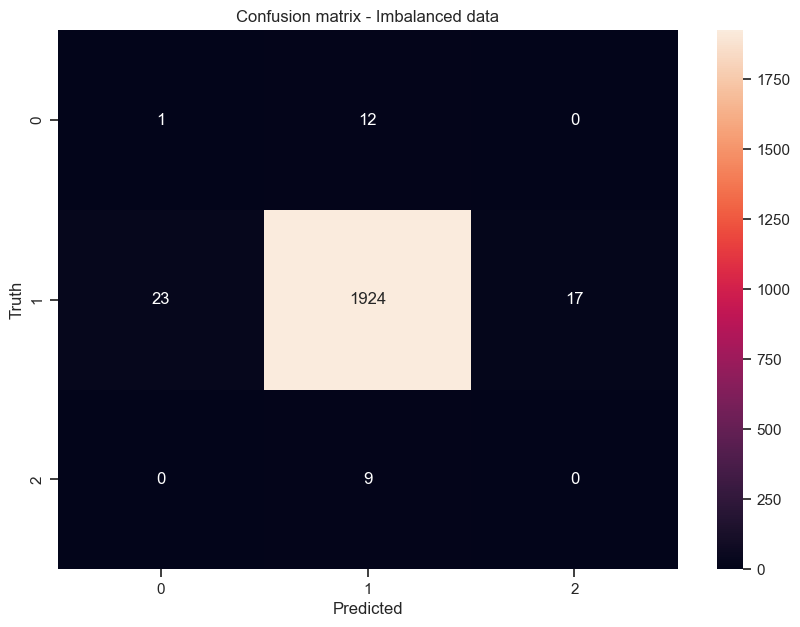

In [17]:
# Model 1: Decision tree without SMOTE analysis - Imbalanced dataset

# Identify predictors and target variable
X_1 = buy_sell_data_2[['close', 'lower_bollinger_band', 'upper_bollinger_band', 'rsi']]
y_1 = buy_sell_data_2['signal']

# Split data into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_1 = DecisionTreeClassifier()

# Fit the model to the training data
model_1.fit(X_train_1, y_train_1)

# Make predictions on the test set
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the model's accuracy
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for default Decision tree model: {accuracy_1*100:.2f}%")

# Classification report
print("Classification Report - Model 1\n")
print(classification_report(y_test_1, y_pred_1))

# Visualize the confusion matrix
cm_1 = confusion_matrix(y_test_1, y_pred_1)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Imbalanced data for Strategy II")
plt.show()


 0    6520
 1    3260
-1    3260
Name: signal, dtype: int64
Accuracy for Decision tree model with SMOTE: 98.10%
Classification Report - Model 2

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      1002
           0       0.98      0.97      0.97      1933
           1       0.97      0.99      0.98       977

    accuracy                           0.97      3912
   macro avg       0.97      0.97      0.97      3912
weighted avg       0.97      0.97      0.97      3912



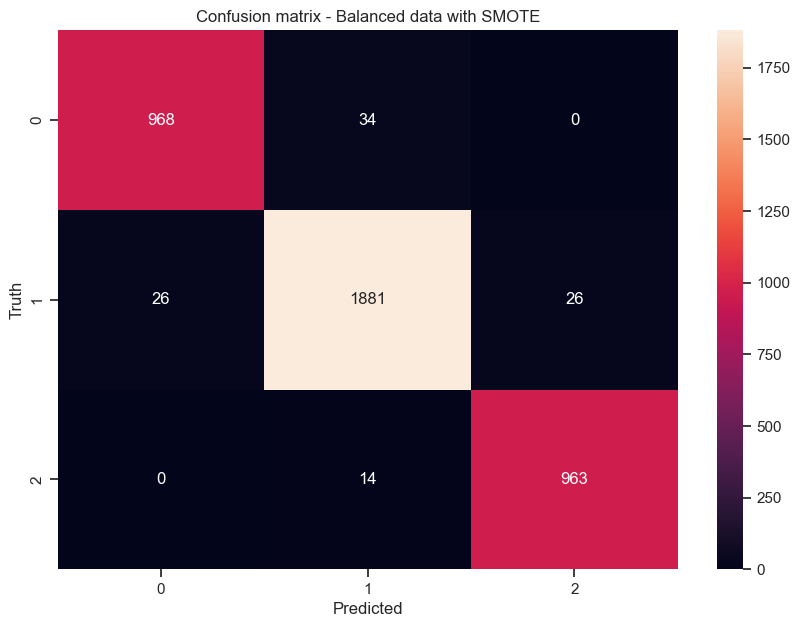

In [40]:
# Model 2: Decision tree model with SMOTE analysis on both train and test set

# Split the data into buy+50% hold and sell+50% hold
df1 = pd.concat([buy_sell_data_2[buy_sell_data_2.signal == 1], buy_sell_data_2[buy_sell_data_2.signal == 0].iloc[:3260]])
df2 = pd.concat([buy_sell_data_2[buy_sell_data_2.signal == -1], buy_sell_data_2[buy_sell_data_2.signal == 0].iloc[:3260]])

# SMOTE Analysis

X1 = df1[['close', 'lower_bollinger_band', 'upper_bollinger_band', 'rsi']]
y1 = df1['signal']
sm = SMOTE(random_state=657)
X1_new, y1_new = sm.fit_resample(X1, y1)

X2 = df2[['close', 'lower_bollinger_band', 'upper_bollinger_band', 'rsi']]
y2 = df2['signal']
sm = SMOTE()
X2_new, y2_new = sm.fit_resample(X2, y2)

# New dataframes with balanced labels

X_new = pd.concat([X1_new, X2_new])
y_new = pd.concat([y1_new, y2_new])

print(y_new.value_counts())

# Split data into train and test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_2 = DecisionTreeClassifier()

# Fit the model to the training data
model_2.fit(X_train_2, y_train_2)

# Make predictions on the test set
y_pred_2 = model_2.predict(X_test_2)

# Evaluate the model's accuracy
accuracy_2 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for Decision tree model with SMOTE: {accuracy_2*100:.2f}%")

# Classification report
print("Classification Report - Model 2\n")
print(classification_report(y_test_2, y_pred_2))

# Visualize the confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Balanced data with SMOTE")
plt.show()

## Strategy III - MACD with 200-day EMA

In [19]:
# Get the technical indicators for the strategy 3

data_strat_3 = mod.macd_with_ema(itc_df, itc_df['close'])

In [20]:
# Identify buy-sell points

buy_sell_data_3 = mod.get_signals_for_strategy_3(data_strat_3.copy(deep=True))

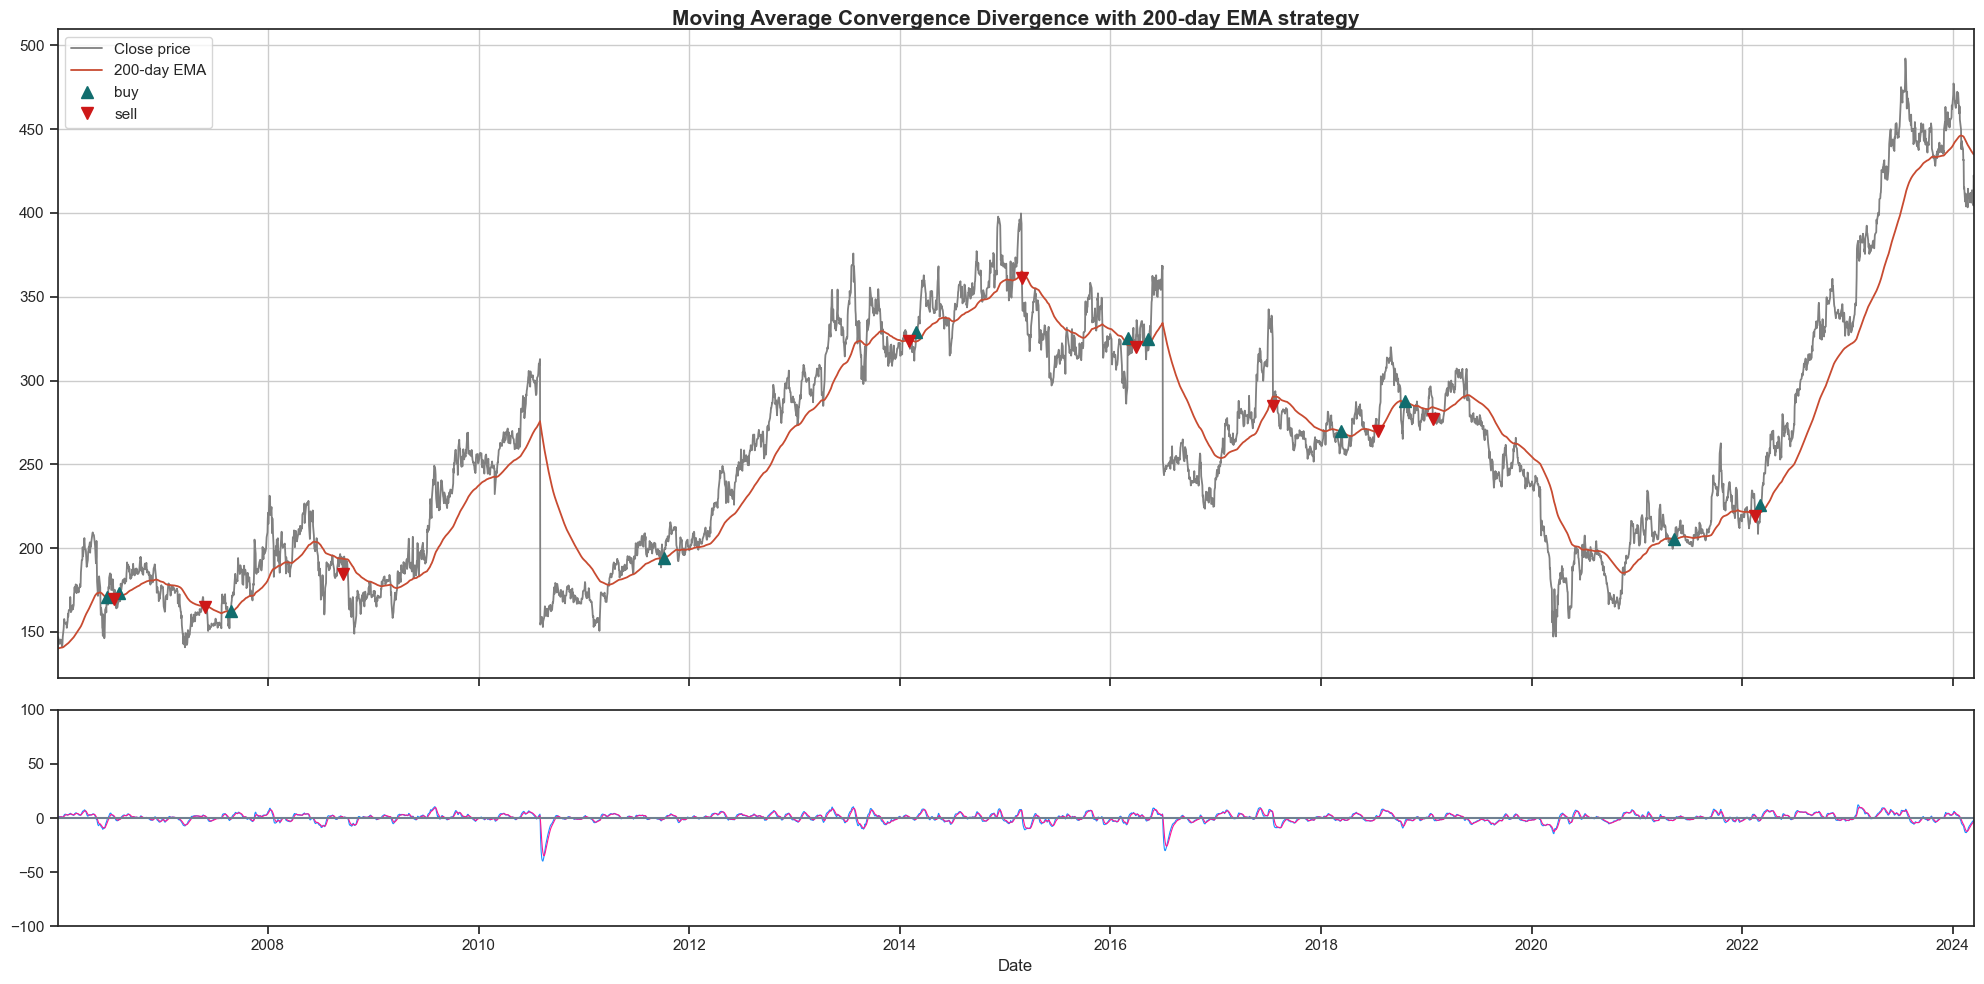

In [21]:
# Visualize the indicators with the identified buy-sell points

buy_signals_3 = buy_sell_data_3.loc[buy_sell_data_3['position'] == 'buy', 'close']
sell_signals_3 = buy_sell_data_3.loc[buy_sell_data_3['position'] == 'sell', 'close']

fig3, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(buy_sell_data_3.close, color='grey', label='Close price', linewidth=1.3)
ax1.plot(buy_sell_data_3.ema_200, color='#C84B31', label='200-day EMA', linewidth=1.3)
ax1.set_xlim([buy_sell_data_3.index[0], buy_sell_data_3.index[-1]])

ax1.plot(buy_signals_3.index,
         buy_signals_3,
         '^', markersize=8, color='#116D6E', label='buy')
ax1.plot(sell_signals_3.index,
         sell_signals_3,
         'v', markersize=8, color='#CD1818', label='sell')
ax1.legend()
ax1.text(x=0.5, y=1, s='Moving Average Convergence Divergence with 200-day EMA strategy', fontsize=15, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

ax1.grid()

ax2.plot(buy_sell_data_3.macd_line, color='dodgerblue', linewidth=0.8)
ax2.plot(buy_sell_data_3.signal_line, color='deeppink', linewidth=0.8)
ax2.axhline(y=0, color='slategrey', linestyle='-')

ax2.set_ylim([-100, 100])

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [22]:
# Calculate returns

cum_ret_3, portfolio_amount_3 = mod.calculate_cumulative_returns(buy_sell_data_3)

annual_return_3 = mod.calculate_annual_return(buy_sell_data_3, cumulative_return=cum_ret_3)

return_on_investment_3 = mod.calculate_roi(portfolio_amount_3)

print(f"ROI of strategy 2: {return_on_investment_3:.2f}%")
print(f"Annual Return of strategy 2: {annual_return_3 * 100:.2f}%")
print(f"Portfolio Amount at the End of the Investment Period: {portfolio_amount_3:.2f}")

ROI of strategy 2: 73.92%
Annual Return of strategy 2: -2.98%
Portfolio Amount at the End of the Investment Period: 17391.87


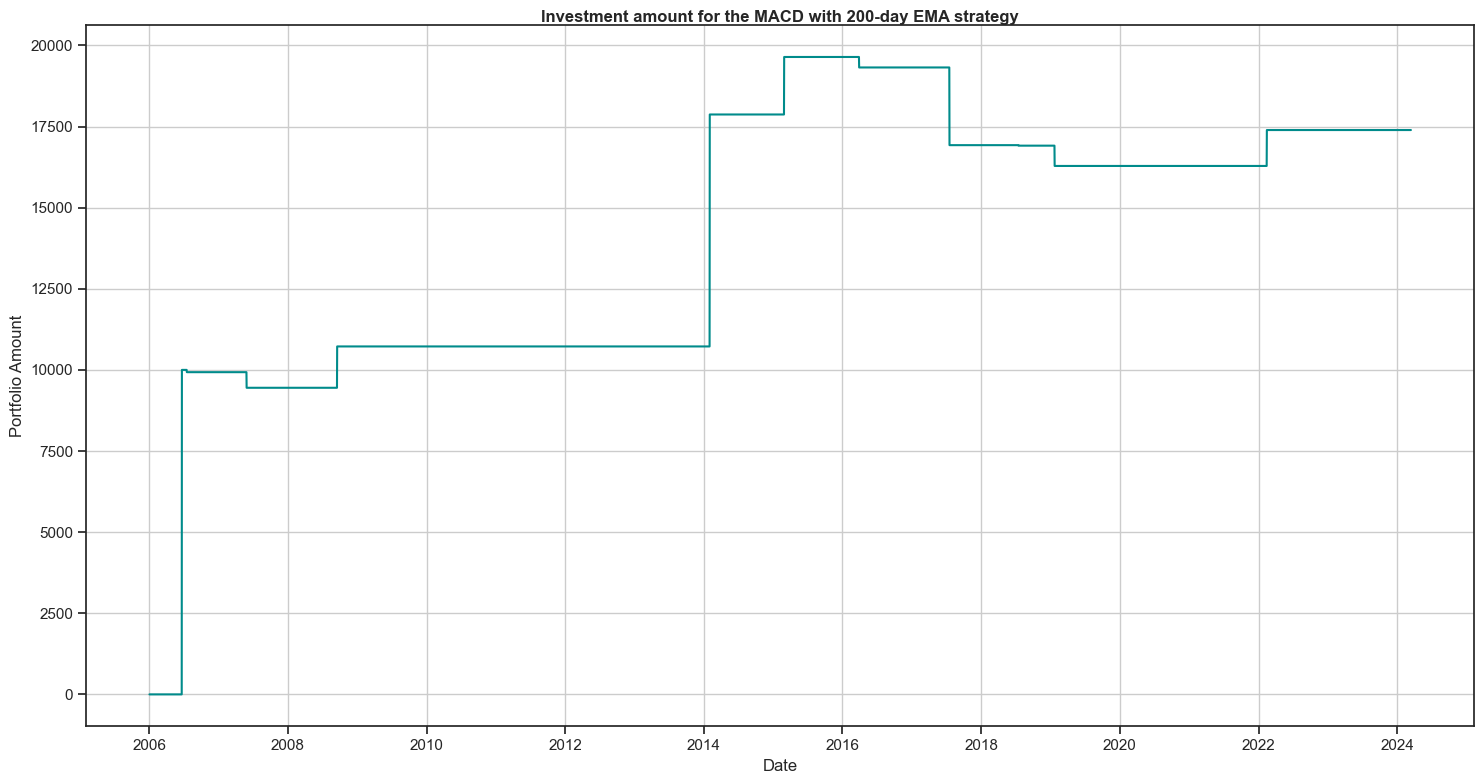

In [23]:
# Visualize the cumulative returns over the investment period

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 8))

# Plot the cumulative returns
ax1.plot(buy_sell_data_3.index, buy_sell_data_3['investment_value'], color='darkcyan', label='Portfolio Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Amount')
ax1.tick_params('y')
ax1.grid()
ax1.text(x=0.5, y=1, s='Investment amount for the MACD with 200-day EMA strategy', fontsize=12, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

plt.tight_layout()
plt.show()

In [27]:
buy_sell_data_3['signal'].value_counts()

 0    6626
 1      11
-1      10
Name: signal, dtype: int64

Accuracy for default Decision tree model: 99.50%
Classification Report - Model 1

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       1.00      1.00      1.00      1990
           1       0.00      0.00      0.00         1

    accuracy                           0.99      1995
   macro avg       0.33      0.33      0.33      1995
weighted avg       0.99      0.99      0.99      1995



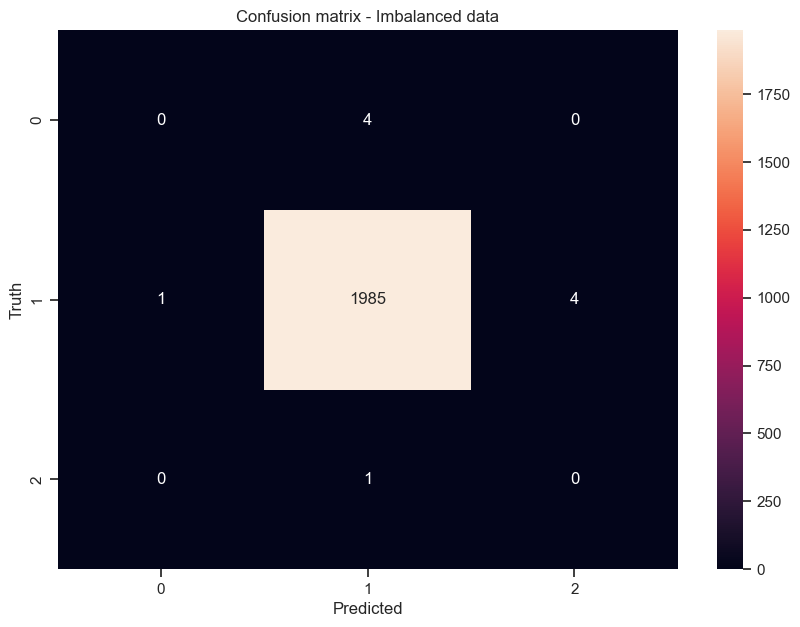

In [24]:
# Model 1: Decision tree without SMOTE analysis - Imbalanced dataset

# Identify predictors and target variable
X_1 = buy_sell_data_3[['close', 'macd_line', 'signal_line', 'ema_200']]
y_1 = buy_sell_data_3['signal']

# Split data into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_1 = DecisionTreeClassifier()

# Fit the model to the training data
model_1.fit(X_train_1, y_train_1)

# Make predictions on the test set
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the model's accuracy
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for default Decision tree model: {accuracy_1*100:.2f}%")

# Classification report
print("Classification Report - Model 1\n")
print(classification_report(y_test_1, y_pred_1))

# Visualize the confusion matrix
cm_1 = confusion_matrix(y_test_1, y_pred_1)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Imbalanced data")
plt.show()


 0    6626
 1    3313
-1    3313
Name: signal, dtype: int64
Accuracy for Decision tree model with SMOTE: 98.10%
Classification Report - Model 2

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       999
           0       0.99      0.99      0.99      1987
           1       0.99      1.00      0.99       990

    accuracy                           0.99      3976
   macro avg       0.99      0.99      0.99      3976
weighted avg       0.99      0.99      0.99      3976



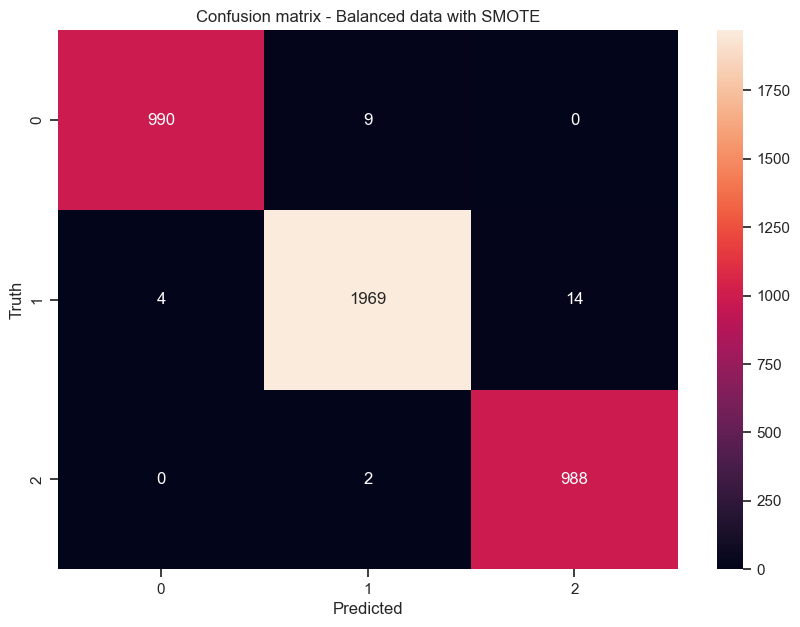

In [41]:
# Model 2: Decision tree model with SMOTE analysis on both train and test set

# Split the data into buy+50% hold and sell+50% hold
df1 = pd.concat([buy_sell_data_3[buy_sell_data_3.signal == 1], buy_sell_data_3[buy_sell_data_3.signal == 0].iloc[:3313]])
df2 = pd.concat([buy_sell_data_3[buy_sell_data_3.signal == -1], buy_sell_data_3[buy_sell_data_3.signal == 0].iloc[:3313]])

# SMOTE Analysis

X1 = df1[['close', 'macd_line', 'signal_line', 'ema_200']]
y1 = df1['signal']
sm = SMOTE(random_state=657)
X1_new, y1_new = sm.fit_resample(X1, y1)

X2 = df2[['close', 'macd_line', 'signal_line', 'ema_200']]
y2 = df2['signal']
sm = SMOTE()
X2_new, y2_new = sm.fit_resample(X2, y2)

# New dataframes with balanced labels

X_new = pd.concat([X1_new, X2_new])
y_new = pd.concat([y1_new, y2_new])

print(y_new.value_counts())

# Split data into train and test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_2 = DecisionTreeClassifier()

# Fit the model to the training data
model_2.fit(X_train_2, y_train_2)

# Make predictions on the test set
y_pred_2 = model_2.predict(X_test_2)

# Evaluate the model's accuracy
accuracy_2 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for Decision tree model with SMOTE: {accuracy_2*100:.2f}%")

# Classification report
print("Classification Report - Model 2\n")
print(classification_report(y_test_2, y_pred_2))

# Visualize the confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Balanced data with SMOTE")
plt.show()

## Strategy IV - MACD with RSI

In [29]:
# Get the technical indicators for the strategy 4

data_strat_4 = mod.macd_with_rsi(itc_df, itc_df['close'])

In [30]:
# Get the buy-sell points

buy_sell_data_4 = mod.get_signals_for_strategy_4(data_strat_4.copy(deep=True))

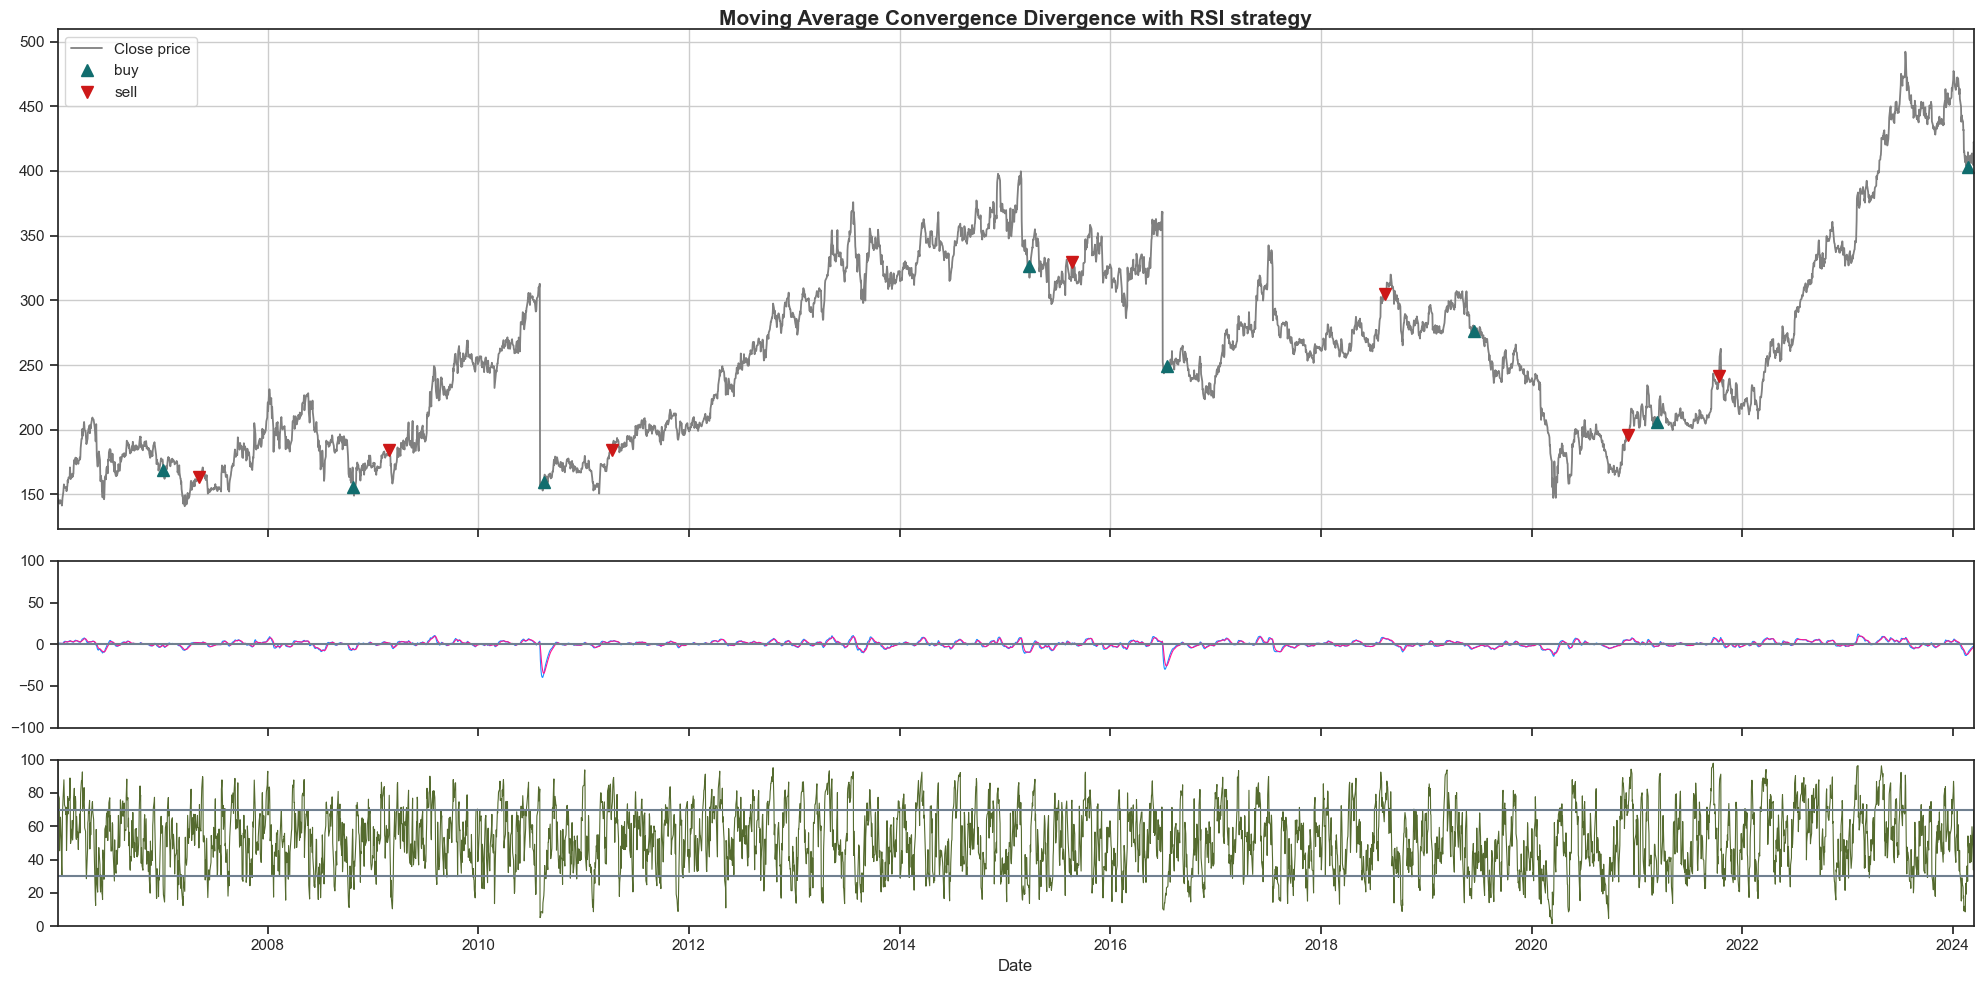

In [31]:
# Visualize the price with indicators (macd & rsi)

buy_signals_4 = buy_sell_data_4.loc[buy_sell_data_4['position'] == 'buy', 'close']
sell_signals_4 = buy_sell_data_4.loc[buy_sell_data_4['position'] == 'sell', 'close']

fig4, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [3, 1, 1]})

ax1.plot(buy_sell_data_4.close, color='grey', label='Close price', linewidth=1.3)
ax1.set_xlim([buy_sell_data_4.index[0], buy_sell_data_4.index[-1]])

ax1.plot(buy_signals_4.index,
         buy_signals_4,
         '^', markersize=8, color='#116D6E', label='buy')
ax1.plot(sell_signals_4.index,
         sell_signals_4,
         'v', markersize=8, color='#CD1818', label='sell')
ax1.legend()
ax1.text(x=0.5, y=1, s='Moving Average Convergence Divergence with RSI strategy', fontsize=15, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

ax1.grid()

ax2.plot(buy_sell_data_4.macd_line, color='dodgerblue', linewidth=0.8)
ax2.plot(buy_sell_data_4.signal_line, color='deeppink', linewidth=0.8)
ax2.axhline(y=0, color='slategrey', linestyle='-')
ax2.set_ylim([-100, 100])

ax3.plot(buy_sell_data_4.rsi, color='darkolivegreen', linewidth=0.8)
ax3.axhline(y=30, color='slategrey', linestyle='-')
ax3.axhline(y=70, color='slategrey', linestyle='-')
ax3.set_ylim([0, 100])

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [32]:
# Calculate returns

cum_ret_4, portfolio_amount_4 = mod.calculate_cumulative_returns(buy_sell_data_4)

annual_return_4 = mod.calculate_annual_return(buy_sell_data_4, cumulative_return=cum_ret_4)

return_on_investment_4 = mod.calculate_roi(portfolio_amount_4)

print(f"ROI of strategy 2: {return_on_investment_4:.2f}%")
print(f"Annual Return of strategy 2: {annual_return_4 * 100:.2f}%")
print(f"Portfolio Amount at the End of the Investment Period: {portfolio_amount_4:.2f}")

ROI of strategy 2: 36.31%
Annual Return of strategy 2: -1.92%
Portfolio Amount at the End of the Investment Period: 13630.57


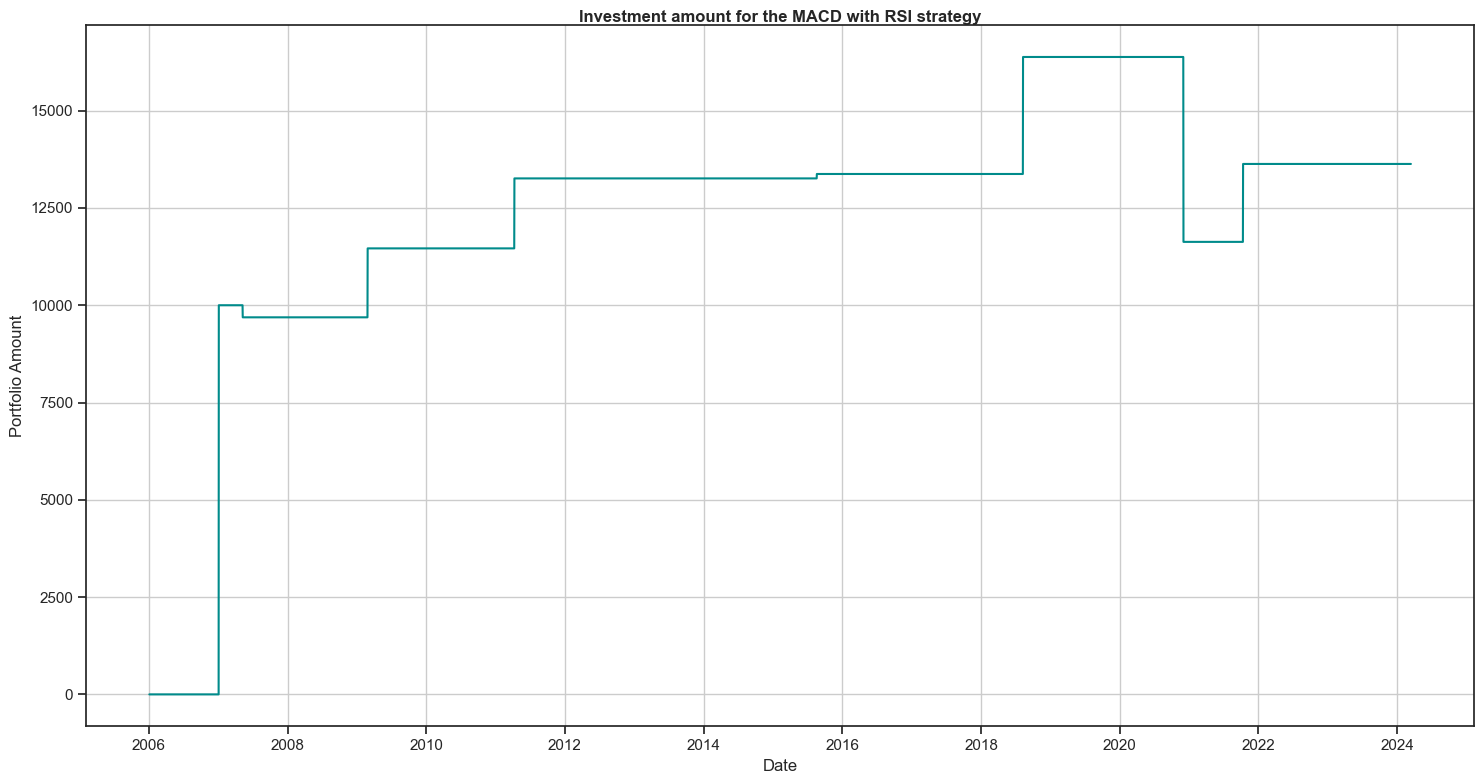

In [33]:
# Visualize the cumulative returns over the investment period

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 8))

# Plot the cumulative returns
ax1.plot(buy_sell_data_4.index, buy_sell_data_4['investment_value'], color='darkcyan', label='Portfolio Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Amount')
ax1.tick_params('y')
ax1.grid()
ax1.text(x=0.5, y=1, s='Investment amount for the MACD with RSI strategy', fontsize=12, weight='bold',
         ha='center', va='bottom', transform=ax1.transAxes)

plt.tight_layout()
plt.show()

In [34]:
buy_sell_data_4['signal'].value_counts()

 0    6631
 1       8
-1       7
Name: signal, dtype: int64

Accuracy for default Decision tree model: 99.70%
Classification Report - Model 1

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       1.00      1.00      1.00      1990
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1994
   macro avg       0.33      0.33      0.33      1994
weighted avg       1.00      1.00      1.00      1994



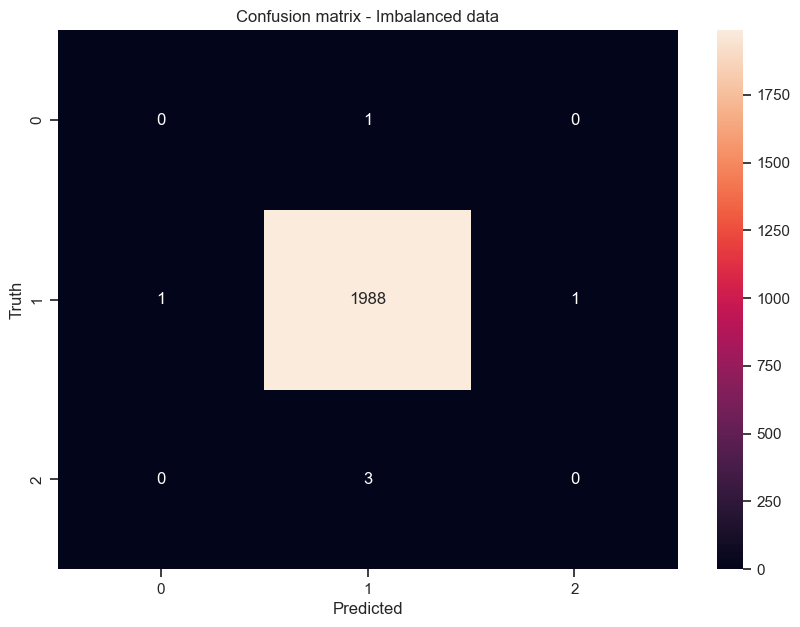

In [35]:
# Model 1: Decision tree without SMOTE analysis - Imbalanced dataset

# Identify predictors and target variable
X_1 = buy_sell_data_4[['close', 'macd_line', 'signal_line', 'rsi']]
y_1 = buy_sell_data_4['signal']

# Split data into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_1 = DecisionTreeClassifier()

# Fit the model to the training data
model_1.fit(X_train_1, y_train_1)

# Make predictions on the test set
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the model's accuracy
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for default Decision tree model: {accuracy_1*100:.2f}%")

# Classification report
print("Classification Report - Model 1\n")
print(classification_report(y_test_1, y_pred_1))

# Visualize the confusion matrix
cm_1 = confusion_matrix(y_test_1, y_pred_1)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Imbalanced data")
plt.show()


 0    6632
 1    3316
-1    3316
Name: signal, dtype: int64
Accuracy for Decision tree model with SMOTE: 98.10%
Classification Report - Model 2

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      1002
           0       0.99      1.00      0.99      1971
           1       1.00      0.99      1.00      1007

    accuracy                           0.99      3980
   macro avg       0.99      0.99      0.99      3980
weighted avg       0.99      0.99      0.99      3980



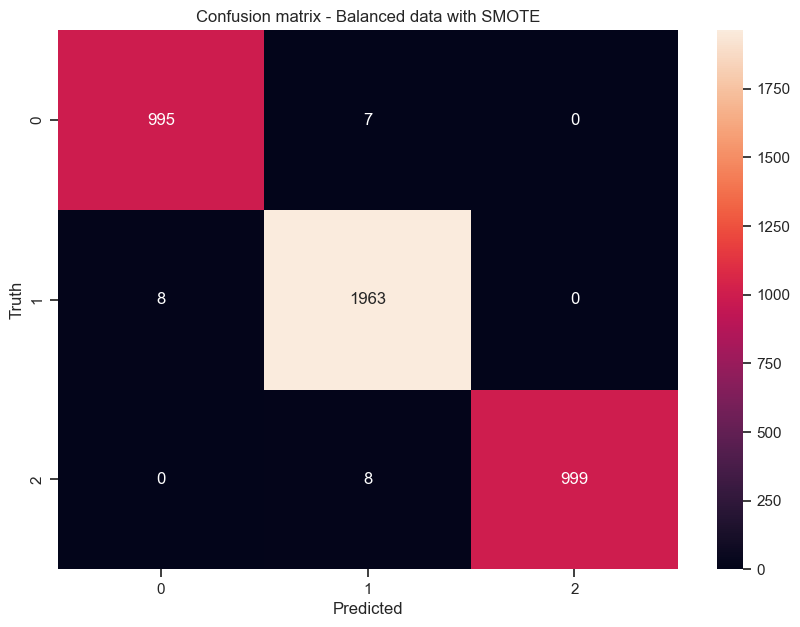

In [42]:
# Model 2: Decision tree model with SMOTE analysis on both train and test set

# Split the data into buy+50% hold and sell+50% hold
df1 = pd.concat([buy_sell_data_4[buy_sell_data_4.signal == 1], buy_sell_data_4[buy_sell_data_4.signal == 0].iloc[:3316]])
df2 = pd.concat([buy_sell_data_4[buy_sell_data_4.signal == -1], buy_sell_data_4[buy_sell_data_4.signal == 0].iloc[:3316]])

# SMOTE Analysis

X1 = df1[['close', 'macd_line', 'signal_line', 'rsi']]
y1 = df1['signal']
sm = SMOTE(random_state=657)
X1_new, y1_new = sm.fit_resample(X1, y1)

X2 = df2[['close', 'macd_line', 'signal_line', 'rsi']]
y2 = df2['signal']
sm = SMOTE()
X2_new, y2_new = sm.fit_resample(X2, y2)

# New dataframes with balanced labels

X_new = pd.concat([X1_new, X2_new])
y_new = pd.concat([y1_new, y2_new])

print(y_new.value_counts())

# Split data into train and test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.3, random_state=789)

# Initialize the Decision Tree Classifier with default parameters
model_2 = DecisionTreeClassifier()

# Fit the model to the training data
model_2.fit(X_train_2, y_train_2)

# Make predictions on the test set
y_pred_2 = model_2.predict(X_test_2)

# Evaluate the model's accuracy
accuracy_2 = accuracy_score(y_test_1, y_pred_1)
print(f"Accuracy for Decision tree model with SMOTE: {accuracy_2*100:.2f}%")

# Classification report
print("Classification Report - Model 2\n")
print(classification_report(y_test_2, y_pred_2))

# Visualize the confusion matrix
cm_2 = confusion_matrix(y_test_2, y_pred_2)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix - Balanced data with SMOTE")
plt.show()